### Feature Extraction for Point Clouds 21.4.24

- Testing frature extraction in out data with different modules
- Maily focused in Decision Tree for 3D data:
    - New features to use: distance/relative position to k Nearest neighbours

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Stats module
from scipy.spatial import KDTree

# 3D Libs
import open3d as o3d
import laspy
import pyvista as pv
print(laspy.__version__)

# Geospatial libs
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh    

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.3


In [2]:
def get_coord(points):
    
    x_vals = [punto[0] for punto in points]
    y_vals = [punto[1] for punto in points]
    z_vals = [punto[2] for punto in points]
    
    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def get_coord2(extremos_apoyos):
    
    x_vals = [extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"]]
    y_vals = [extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"]]
    z_vals = extremos_apoyos[0]["COORDENADAS_Z"] + extremos_apoyos[1]["COORDENADAS_Z"]

    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def unravel_data_element(element):
    
    for key in element.keys():
    
        if type(element[key]) in [list, dict]:
            
            print(f"\n{key}: ")
            
            if type(element[key]) == list:
            
                element2 = element[key][0]
                print(f"- Length of list: {len(element[key])}")
                
            else:
                
                element2 = element[key]
            
            for key2 in element2.keys():
                
                print(f"    {key2}: {element2[key2]}")
                
                if type(element2[key2]) == list:
                    print(f"    - Length of list: {len(element2[key2])}")
        
        else:
            print(f"\n{key}: {element[key]}")

In [3]:
# Obtenemos datos json con 25 elementos = vanos

import json

path = "../data/"

with open(path+'vanos.json', 'r') as archivo:
    data = json.load(archivo)
    
len(data)

25

In [4]:
for i,element in enumerate(data[:5]):
    print(f"\n-------------Vano {i} -------------")
    unravel_data_element(element)


-------------Vano 0 -------------

OBJECTID_VANO_2D: 1

ID_VANO: C_13417203_13419734

LONGITUD_2D: 30.689231010239173

COORDENADA_X_INICIO: 382920.926

COORDENADA_Y_INICIO: 4460158.522

COORDENADA_X_FIN: 382932.7259999998

COORDEANDA_Y_FIN: 4460130.192

APOYOS: 
- Length of list: 2
    OBJECTID_APOYO_3D: 24
    COD_APOYO: 13417203
    COORDENADA_X: 382920.926
    COORDEANDA_Y: 4460158.522
    COORDENADAS_Z: [630.0673999999999, 640.8108999999968]
    - Length of list: 2

CONDUCTORES: 
- Length of list: 3
    OBJECTID_VANO_3D: 34
    LONGITUD_2D: 29.87078481349692
    LONGITUD_3D: 29.871002731482523
    VERTICES: [[382933.8239000002, 4460130.8259, 640.4247000000032], [382921.98819999956, 4460158.251800001, 640.5387999999948]]
    - Length of list: 2

LIDAR: 
    CONDUCTORES: [[382926.6312, 4460140.5801, 640.4769], [382926.6036, 4460140.7243, 640.5184], [382926.564, 4460140.8224, 640.4435], [382926.5272, 4460140.9143, 640.3385], [382926.4928, 4460141.0978, 640.4241], [382926.5985, 446014

In [5]:
# Count proportion of points

vano = 3

#Número de puntos conductores:
numero_punti = len(data[vano]['LIDAR']['CONDUCTORES'])
print("Numero di punti conductores:", numero_punti)

#Número de puntos de apoyo:
numero_punti = len(data[vano]['LIDAR']['APOYOS'])
print("Numero di punti apoyos:", numero_punti)

Numero di punti conductores: 2083
Numero di punti apoyos: 4239


In [6]:
# Extract data coordinates

puntos_conductores = data[vano]['LIDAR']['CONDUCTORES']
puntos_apoyos = data[vano]['LIDAR']['APOYOS']

extremos_apoyos = data[vano]['APOYOS']
puntos_vertices = [element['VERTICES'][vano] for element in data[vano]['CONDUCTORES']]

x_vals_conductores, y_vals_conductores, z_vals_conductores = get_coord(puntos_conductores)
x_vals_apoyos, y_vals_apoyos, z_vals_apoyos = get_coord(puntos_apoyos)
x_vals_vert, y_vals_vert, z_vals_vert = get_coord(puntos_vertices)

In [7]:
# Define conductor coordinates
xyz = np.array([x_vals_conductores, 
            y_vals_conductores , z_vals_conductores]).transpose()

# # Create a point cloud using PyVista
point_cloud = pv.PolyData(xyz)

# Visualize the point cloud
point_cloud.plot(eye_dome_lighting=True)

Widget(value='<iframe src="http://localhost:38953/index.html?ui=P_0x7f02f25ad750_0&reconnect=auto" class="pyvi…

In [8]:
# Explore pyvista capabilities

# Store z coord
point_cloud['elevation'] = point_cloud.points[:,2]

# Render as spheres

pv.plot(point_cloud, scalars = point_cloud["elevation"],
        render_points_as_spheres= True, point_size=5, show_scalar_bar=False)

Widget(value='<iframe src="http://localhost:38953/index.html?ui=P_0x7f02ea67d510_1&reconnect=auto" class="pyvi…

In [9]:
# Preprocess cloud and create 3D data sctructure

# KD Tree Pyvista - Limited and less efficient

temp = point_cloud.find_closest_point((1,1,0), n = 20)
print(temp)

[193  61 151 315 131  69 259  16  48   9 311 197 226 340  56  51  11 214
 206 356]


In [10]:
# KNN structure with SciPy
tree = KDTree(point_cloud.points)

# Build KD Trees for each point cloud
t0 = time.time()

# KNN Search and indexing
dist, idx = tree.query(point_cloud.points, k = 50)

# Find NN for each point in the cloud
neighbors = point_cloud.points[idx]

t1 = time.time()
print(f"NN Computation for k = 50 in {t1-t0}s")
neighbors

NN Computation for k = 50 in 0.018790483474731445s


pyvista_ndarray([[[3.82789030e+05, 4.46048288e+06, 6.48866300e+02],
                  [3.82789080e+05, 4.46048280e+06, 6.48875900e+02],
                  [3.82789840e+05, 4.46048337e+06, 6.48767900e+02],
                  ...,
                  [3.82791910e+05, 4.46047811e+06, 6.49004400e+02],
                  [3.82791956e+05, 4.46047801e+06, 6.49016900e+02],
                  [3.82791969e+05, 4.46047798e+06, 6.49018300e+02]],

                 [[3.82788323e+05, 4.46048469e+06, 6.48779100e+02],
                  [3.82788410e+05, 4.46048457e+06, 6.48838100e+02],
                  [3.82788415e+05, 4.46048444e+06, 6.48748600e+02],
                  ...,
                  [3.82790505e+05, 4.46047919e+06, 6.48982100e+02],
                  [3.82786174e+05, 4.46049026e+06, 6.48707200e+02],
                  [3.82786202e+05, 4.46049028e+06, 6.48688600e+02]],

                 [[3.82788415e+05, 4.46048444e+06, 6.48748600e+02],
                  [3.82788410e+05, 4.46048457e+06, 6.48838100e+02]

In [11]:
# Point CLoud Data Featuring: PCA

# Compute PCA for a subcloud

X = point_cloud.points

# Compute the mean

mean = np.mean(X, axis = 0)

# Center the data 
centered = X - mean

# Compute covariance matrix
cov_mat = np.cov(centered, rowvar = False)

# Get eigenvalues and eigenvectors

eig_val, eig_vect = np.linalg.eig(cov_mat)

# Sort the eig val by decreasing
sorted_idx = np.argsort(eig_val)[::-1]
sorted_eigval = eig_val[sorted_idx]
sorted_eigvect = eig_vect[:, sorted_idx]

print("Sorted", sorted_idx)
print("Eigenvalues", sorted_eigval)
print("Eigenvectors", sorted_eigvect)

Sorted [0 1 2]
Eigenvalues [1.11035855e+03 4.38831400e-01 8.51440541e-02]
Eigenvectors [[-0.36424756  0.92956243 -0.05689821]
 [ 0.93054331  0.36573673  0.01804964]
 [-0.03758803  0.04637172  0.99821681]]


In [12]:
# Define PCA function

sel = 1

def PCA(cloud):
    
    mean = np.mean(cloud, axis = 0) 
    # Center the data 
    cloud = cloud - mean
    
    # Compute covariance matrix
    cov_mat = np.cov(cloud, rowvar = False)

    # Get eigenvalues and eigenvectors

    eig_val, eig_vect = np.linalg.eig(cov_mat)

    # Sort the eig val by decreasing
    sorted_idx = np.argsort(eig_val)[::-1]
    sorted_eigval = eig_val[sorted_idx]
    sorted_eigvect = eig_vect[:, sorted_idx]

    return sorted_eigval, sorted_eigvect

# Single unit test
f_val, f_vect = PCA(neighbors[sel])

print("Eigenvalues", f_val)
print("Eigenvectors", f_vect)

Eigenvalues [1.17132356e+01 4.33872586e-01 2.97776329e-03]
Eigenvectors [[ 3.92895340e-01 -9.19531785e-01 -9.72356040e-03]
 [-9.19200098e-01 -3.93014890e-01  2.47078392e-02]
 [ 2.65411475e-02  7.69697225e-04  9.99647425e-01]]


In [13]:
# Definte PCA_based features

def PCA_featuring(val, vect):
    
    planarity = (val[1] - val[2])/val[0]
    linearity = (val[0] - val[1])/val[0]
    omnivariance = (val[0] * val[1] * val[2])**(1/3)
    _, _, normal = vect
    verticality = 1 - normal[2]
    
    return planarity, linearity, omnivariance, verticality, normal

# Extract features for PCA values and vectors

pla, lin, omn, vert, norm = PCA_featuring(f_val, f_vect)

pla, lin, omn, vert, norm

(0.03678700211557836,
 0.9629587757898511,
 0.2473487688780706,
 0.0003525746275045982,
 array([2.65411475e-02, 7.69697225e-04, 9.99647425e-01]))

In [14]:
# Understanding Feature Neighborhood Definition
#KNN Search

t0 = time.time()
tree_temp = KDTree(point_cloud.points)
_, idx_temp = tree_temp.query(point_cloud.points, k = 50)
t1 = time.time()

print(f"NN Computation for k = 50 in {t1-t0}s")

NN Computation for k = 50 in 0.01619863510131836s


In [15]:
# Radius Search

t0 = time.time()
tree_temp = KDTree(point_cloud.points)
idx_temp = tree_temp.query_ball_point(point_cloud.points, 1)
t1 = time.time()

print(f"Radius Computation in {t1-t0}s")

Radius Computation in 0.01932978630065918s


In [16]:
# Custom search

t0 = time.time()
tree_2d = KDTree(point_cloud.points[:, 0:2])
idx_temp = tree_2d.query_ball_point(point_cloud.points[:, 0:2], 1)
t1 = time.time()

print(f"Radius Computation in {t1-t0}s")

Radius Computation in 0.023260116577148438s


In [17]:
# Relative Featuring

t0 = time.time()

sel = 1
selection = point_cloud.points[idx_temp[sel]]

d_hight = np.array(np.max(selection, axis = 0) - point_cloud.points[sel])[2]
d_low = np.array(point_cloud.points[sel] - np.min(selection, axis = 0))[2]

In [35]:
# Extract data coordinates

vano =3 

puntos_conductores = data[vano]['LIDAR']['CONDUCTORES']
puntos_apoyos = data[vano]['LIDAR']['APOYOS']

extremos_apoyos = data[vano]['APOYOS']
puntos_vertices = [element['VERTICES'][vano] for element in data[vano]['CONDUCTORES']]

x_vals_conductores, y_vals_conductores, z_vals_conductores = get_coord(puntos_conductores)
x_vals_apoyos, y_vals_apoyos, z_vals_apoyos = get_coord(puntos_apoyos)
x_vals_vert, y_vals_vert, z_vals_vert = get_coord(puntos_vertices)

# Define conductor coordinates
xyz_conduc = np.array([x_vals_conductores, 
            y_vals_conductores , z_vals_conductores]).transpose()
xyz_apoyo = np.array([x_vals_conductores, 
            y_vals_conductores , z_vals_conductores]).transpose()

# # Create a point cloud using PyVista
point_cloud_conduc = pv.PolyData(xyz_conduc)
point_cloud_apoyo = pv.PolyData(xyz_apoyo)

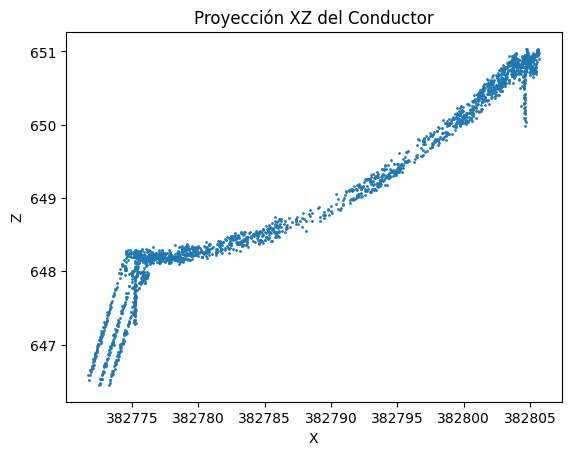

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que 'puntos' es tu array de puntos 3D
# puntos = np.array([...])

# Definir la matriz de proyección XZ (elimina la componente Y)
matriz_proyeccion_xz = np.array([[1, 0, 0],
                                 [1, 1, 0],
                                 [0, 0, 1]])

# Proyectar los puntos
puntos_proyectados_xz = point_cloud.points @ matriz_proyeccion_xz.T

# Ahora 'puntos_proyectados_xz' contiene solo las componentes 'X' y 'Z'
# Puedes graficarlos para ver la proyección XZ
plt.scatter(point_cloud_conduc.points[:, 0], point_cloud_conduc.points[:, 2], s = 1)
plt.scatter(point_cloud_apoyo.points[:, 0], point_cloud_apoyo.points[:, 2], s = 1)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Proyección XZ del Conductor')
plt.show()
